# TransPoemer

The **TransPoemer transforms regular sentences into poems**, this by means of a Transformer. The transformation goes as follows:
1. First, the keywords of the input sentence are extracted
2. Out of the extracted keywords, only the *most important* once are kept, this to exploit the model's creativity whilst still creating a poem related to the input sequence
2. The keywords are translated to a poem by means of the Transformer

In other words, the Transformer performs a **machine-translation** task, translating keywords to sentences.

# Transformer

## 1. Overview

Transformers were first introduced in the paper [Attention is all you need](https://arxiv.org/abs/1706.03762) and have since then become quite popular, with most of its applications in research fields related to Natural Language Processing (**NLP**).

In contrast to Recurrent Neural Networks (RNNs), which are often used for Sequence-to-Sequence tasks, the Transformer does not use any recurrence. Instead, the model is entirely made up of linear layers which are connected with the addition of **attention**.

There are many variants of the Transformer, with the most popular one being [BERT](https://arxiv.org/abs/1810.04805) (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers).

## 2. Components

A Transformer is made up of an encoder and decoder. The encoder *encodes* the input sentence into a context vector, and the decoder then *decodes* this context vector to create an output. 

The image below, representing the default configuration of a Transformer, was taken directly from the original Transformer paper.

![transformer](notebook_images/transformer1.png)

### 2.1. Encoder

The **objective** of an encoder is to produce a sequence of **context vectors** that represent the given input.

First, the tokens are passed through a standard embedding layer. Next, a **positional encoding** is applied to go against the lack of recurrency present in the model. In other words, without this positional encoding, the model wouldn't be able to know which inputs were neighbouring and which weren't. This positional encoding is applied linearly.

Next, the input token and positional embeddings are elementwise summed together to get a vector which contains information about the token and also its position within the sequence. Afterwards, dropout is applied to the combined embeddings to add a form of regularization to the model.


The combined embeddings (discussed above) are passed through *N* encoder layers, which results in output that can be used by the decoder.

![encoder](notebook_images/transformer-encoder.png)

### 2.2. Decoder

The **objective** of the decoder is to take the encoder representation of the source sentence, and convert it into tokens that try to **approximate the target tokens** as good as possible. Based on *how good* these predicted tokens match their targets, a **loss** is determined. This loss is used to calculate the gradiens that will determine how the model's parameters are updated, this to improve later predictions. 

The implementation of the decoder is similar to that of the encoder, however, a decoder has two multi-head attention layers, where the encoder only had one. As with the encoder, the decoder also consists out of multiple layers. Note that this number does not have to be equal to that of the encoder.

![decoder](notebook_images/transformer-decoder.png)

### 2.3. Sequence-to-Sequence

Transformers have mutliple application areas such as machine translation or question answering. For our purpose, we want to *translate* a sentence of keywords to a poem, hence, we're interested in the **machine translation task**. This task is also called *sequence-to-sequence* (seq2seq) since an input sequence of keywords is translated into an output sequence representing the poem. This output sequence is predicted one token at a time by the model.

The training of this type of Transformers happens by extending the mask of the target sequence one iteration at a time:

$$
\begin{array}{cccc} 
1 & 0 & 0 & 0\\ 
1 & 1 & 0 & 0\\ 
1 & 1 & 1 & 0\\ 
1 & 1 & 1 & 1\\
\end{array}
$$ 

## 3. Chosen Implementation

The Transformer implemented in this project is **mainly influenced by the [pytorch-seq2seq](https://github.com/bentrevett/pytorch-seq2seq) implementation**, which on its part is based on the [HuggingFace](https://huggingface.co/transformers/) implementation. The main differences between the former and the latter being:
* This implementation uses **learned positional encoding** instead of a static one
* A **standard Adam optimizer with static learning rate** is used instead of one with warm-op and cool-down steps, this to simplify the training process
* Label smoothing is not used

The resulting Transformer is a slightly simplified version, but one which should suffice for our goal.

Since the Transformer should be able to train on a laptop (4GB of GPU-memory, supported by NVIDIA's CUDA), the model's parameters were deliberately chosen small. Another benefit of using a smaller model is that less data samples are needed to train the model on.

This simplified model, implemented using the [pytoch-seq2seq library](https://github.com/bentrevett/pytorch-seq2seq/), has the following configuration:
* Dimension of the hidden layer: `128`
* Number of encoder layers (for each head): `3`
* Number of decoder layers (for each head): `3`
* Number of encoder heads: `8`
* Number of decoder heads: `8`
* Dimension of the encoder's point-wise feedforward layer: `256`
* Dimension of the decoder's point-wise feedforward layer: `256`
* Dropout ratio present in the encoder: `0.1` <br> $\rightarrow$ Dropout is applied on the positional encoded embeddings
* Dropout ratio present in the decoder: `0.1` <br> $\rightarrow$ Dropout is applied on the combined embeddings

# Data

Two different types of datasets were used to train the model on. A first dataset that consists of [quotes](https://www.kaggle.com/manann/quotes-500k) is used to pre-train the model. The raw quotes dataset contains more than **500,000 samples**. The second dataset that consists of [limericks](https://raw.githubusercontent.com/sballas8/PoetRNN/master/data/limericks.csv) is used to fine-tune the model on our target task. The latter dataset contains around **90,000 samples**.

For both the datasets, the same *general* processing applied: for each sentence, the *most important* keywords were extracted using the [Natural Language ToolKit](https://www.nltk.org/) (NLTK), which is based on the **TF-IDF rule**. The model's inputs are these keywords, with the corresponding targets the original sentences.

## 1. Processing

Both datasets are processed in the same way. The main steps done during processing are:
* Non-english texts were removed
* Special, non-latin symbols (e.g. ◆ or '\n') were replaced by a blank space
* Sequences exceeding the maximum length (68) were split on a ".", "?" or "!"

The reason why a **maximum length of 68** is chosen is because almost all of the (encoded) limericks fall within this boundary (see below). 

## 2. Quotes

This dataset is used for **pre-training** the model. The pre-training will happen in two phases:
1. First, the Transformer is trained as an **auto-encoder**, which implies that the target-output is equal to the sample's input.
2. Second, the Transformer is trained on the **keyword-to-sentence translation** task, with a sample's most important keywords as input and the sample itself as the target output.

As mentioned before, the [raw quotes dataset](https://www.kaggle.com/manann/quotes-500k) contains around 500,000 samples. Due to the fact a large portion of these samples exceed the sequence length limit of 68 and will be split, the final (processed) dataset has a size of almost **600,000 samples**. The final size-distribution of the processed dataset is shown below.

<img src="data/images/sequence_length_pre-training.png" alt="pre-training data - quotes" style="width: 600px;"/>

## 3. Limericks

The [limericks dataset](https://raw.githubusercontent.com/sballas8/PoetRNN/master/data/limericks.csv) is used to fine-tune the model on the **keyword-to-sentence translation** task. By now, the model should be capable to predict a sentence based on a sequence of keywords to some degree of quality. The limericks are used to fine-tune this translation such that more poem-like output will be predicted. 

In its raw form, the dataset contains a little above **90,000 samples**, which remains almost the same after processing. This is since almost all of the limericks fall within the maximum sequence length (see figure below).

<img src="data/images/sequence_length_combined.png" alt="training data - limericks" style="width: 600px;"/>

## 4. Tokenizer

Since a model can only read numeric inputs, the input-sentences must be tokenized before feeding them to the model. A naive tokenizer would split a sentence to form a list containing each of the sentence's words in order, but this would not be the best tokenizer since the size of the tokenizer's vocabulary would increase dramatically (i.e. increase for every unique word).

Instead of using a hand-made tokenizer, one of the [HuggingFace models](https://huggingface.co/transformers/model_doc/albert.html)'s tokenizer is used: the [AlbertTokenizer](https://huggingface.co/transformers/model_doc/albert.html#alberttokenizer). This tokenizer is able to encode the majority of sentences with only a limited amount of tokens needed. Originally, the tokenizer has a vocabulary size of 30,000 unique tokens. We've decided to decrease this by **pruning the tokens** that were not often used in the limericks training dataset, resulting in a final **vocabulary size of 16,000**. Tokens encoded by the AlbertTokenizer not present in the token-vocabulary will be encoded by the `<unk>` token. This decision has a huge impact on the number of **parameters used by the model**, which is (after the reduction in vocabulary size) *only* **7,036,327**.

# Training

As mentioned above, the training of the model is done in three consecutive steps:
1. Train the model as an **auto-encoder** on a **machine translation** (sequence-to-sequence) task where the input is the same as the output
2. Train the model as a **machine translator** where a **sentence must be predicted based on a limited set of keywords**
3. Train the model as a **machine translator** where a **poem must be predicted based on a limited set of keywords**

Each training process happens in batch-mode, with **batches of 64 samples**, which is the maximum size before running into memory related problems.

## 1. Pre-training the auto-encoder

The pre-training on the auto-encoding task is only ran for **1 epoch** since the model learns fairly quickly that the input is directly mappen upon the target output (note that 1 epoch of training still contains almost **10,000 iterations**). 

The linear mapping between input and output is clearly seen the attention layer of each of the model's heads:

<img src="notebook_images/auto_encoder.png" alt="example of attention in auto-encoder" style="width: 400px;"/>

## 2. Pre-training the keyword-to-sentence translation

During this pre-training phase, each sample has its **five most important keywords extracted**, which are then used as inputs to the model. The goal of the this task is to **predict the original sample** via its extracted keywords.

**10 epochs** of training are executed. **Early stopping** is applied such that the model would stop training if the *best* validation loss hasn't improved (i.e. decreased) in the last three epochs (validation loss is determined after each epoch of training). Each epoch that the validation loss didn't decrease, the **learning rate is halved**.

The progress of the pre-training went as follows:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [20]:
%%capture
"""
My dumb-ass only had text-outputs of the training process, hence, the losses are added below by hand based 
on the last training evaluation.
"""
train_loss = [
    4.012,  # 1
    3.389,
    3.254,
    3.183,
    3.135,  # 5
    3.103,
    3.078,
    3.059,
    3.044,
    3.032,  # 10
]
val_loss = [
    2.988,  # 1
    2.820,
    2.768,
    2.715,
    2.704,  # 5
    2.665,
    2.663,
    2.648,
    2.640,
    2.623,  # 10
]

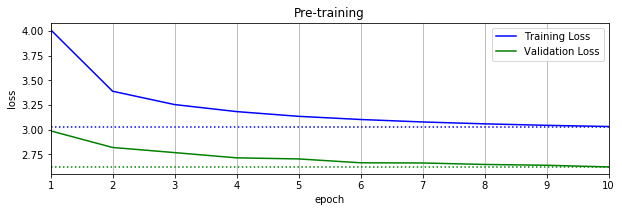

In [21]:
# Plot the losses throughout the pre-training
# Set the figure-shape
plt.figure(figsize=(len(train_loss),(max(train_loss+val_loss)-min(train_loss+val_loss))*2))

# Declare the figure's contents
yticks = range(1,len(train_loss)+1)
plt.plot(yticks, train_loss, label='Training Loss', color='blue')
plt.axhline(min(train_loss), color='blue', linestyle='dotted')
plt.plot(yticks, val_loss, label='Validation Loss', color='green')
plt.axhline(min(val_loss), color='green', linestyle='dotted')

# Adjust how the figure is displayed
plt.legend()
plt.title("Pre-training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.gca().xaxis.grid(True)
plt.xlim(left=1, right=len(train_loss))
plt.show()

In [ ]:
# TODO: Example predictions, heatmap of attention layer?

## 3. Fine-tuning the keyword-to-poem translation

At this point, the model is capable of predicting a well-constructed sentence based on a limited set of keywords. The only problem is that the predicted sentence isn't yet *poem-like*. This problem is resolved by fine-tuning the model on a set of limericks. A **limerick** is a short, usually humorous verse with a strict **rhyming scheme of AABBA** (i.e. the first, second and fifth line rhyme, while the third and fourth lines share a different rhyme).

The model will train over **20 epochs**, with the **same conditions as the previous training**: early stopping when the validation loss hasn't decreased in the last three iterations and halving the learning rate after each epoch the validation loss didn't decrease.

The progress of training is visualized below:

In [35]:
%%capture
"""
My dumb-ass only had text-outputs of the training process, hence, the losses are added below by hand based 
on the last training evaluation.
"""
train_loss = [
    3.414,  # 1
    3.245,
    3.161,
    3.098,
    3.048,  # 5
    3.005,
    2.939,
    2.909,
    2.873,
    2.857,  # 10
    
]
val_loss = [
    3.139,  # 1
    3.094,
    3.085,
    3.048,
    3.040,  # 5
    3.047,
    3.031,
    3.033,
    3.028,
    3.025,  # 10  # Best
    
]

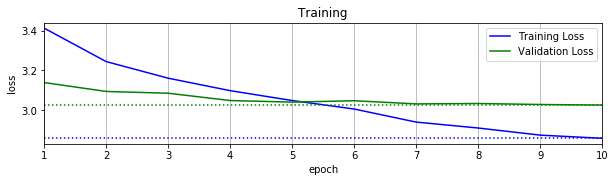

In [36]:
# Plot the losses throughout the pre-training
# Set the figure-shape
plt.figure(figsize=(len(train_loss),(max(train_loss+val_loss)-min(train_loss+val_loss))*4))

# Declare the figure's contents
yticks = range(1,len(train_loss)+1)
plt.plot(yticks, train_loss, label='Training Loss', color='blue')
plt.axhline(min(train_loss), color='blue', linestyle='dotted')
plt.plot(yticks, val_loss, label='Validation Loss', color='green')
plt.axhline(min(val_loss), color='green', linestyle='dotted')

# Adjust how the figure is displayed
plt.legend()
plt.title("Training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.gca().xaxis.grid(True)
plt.xlim(left=1, right=len(train_loss))
plt.show()

# Evaluation

Now we have a fully trained model, it's time to evaluate its performance.

In [ ]:
# TODO: visualize the evaluation of the model

# Using the model

Eventually, the model can be used for its target goal: **transforming regular sentences into poems**. 

In [ ]:
# TODO: Give an environment to perform a hands-on with the model

In [1]:
from tokenizers.tokenizer_main import TokenizerMain

In [2]:
tok = TokenizerMain()

In [12]:
src = "one wants even try even take first step working relationships"
enc = tok.tokenize(src)

In [16]:
src_indexes = [tok.EN.vocab.stoi[token] if token in tok.EN.vocab.stoi else tok.EN.vocab.stoi[tok.EN.unk_token] for token in enc]

In [17]:
src_indexes

[42, 1080, 259, 237, 259, 113, 134, 1476, 1230, 0]